In [1]:
import itertools
from copy import deepcopy, copy

import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from scipy.stats import beta, dirichlet
import matplotlib.pyplot as plt
import pandas as pd


from model import BaseModel
from true_causal_model import TrueCausalModel
from agents.causal_agents import HalfBlindAgent

%matplotlib inline
np.random.seed(0)

## Entrada: Orden parcial y aristas inválidas

In [2]:
DG = nx.DiGraph([("Reaccion", "Final"), ("Tratamiento", "Reaccion"), ("Tratamiento", "Final"), ("Enfermedad", "Final")])
causal_order = list(nx.topological_sort(DG))
invalid_edges = sorted([("Enfermedad", "Tratamiento")])
print(causal_order)

['Enfermedad', 'Tratamiento', 'Reaccion', 'Final']


## Genero creencias p<sub>ij</sub> iniciales

In [3]:
def is_a_valid_edge(x, y, causal_order, invalid_edges):
    if tuple(sorted((x, y))) in invalid_edges or causal_order.index(y) < causal_order.index(x):
        return False
    return True

In [4]:
def create_pij(variables, causal_order, invalid_edges):
    connection_tables = dict()
    for pair in itertools.combinations((variables), 2):
        proba = np.random.rand()
        if is_a_valid_edge(pair[0], pair[1], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[0], pair[1])] = proba
        elif is_a_valid_edge(pair[1], pair[0], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[1], pair[0])] = proba
    return connection_tables
def create_ebunch_from_beliefs(variables, connection_tables):
    ebunch = []
    for pair in connection_tables:
        r = np.random.rand()
        if r <= connection_tables[pair]:
            ebunch.append((pair.split('->')[0], pair.split('->')[1]))
    nodes = []
    for v in variables:
        flag = False
        for edge in ebunch:
            if v in edge:
                flag = True
                break
        if not flag:
            nodes.append(v)
    return ebunch, nodes


In [32]:
def update_connection_beliefs(variables, connection_tables, COMPLETE_MODEL):
    for pair in connection_tables:
        var_one = pair.split("->")[0]
        var_two = pair.split("->")[1]
#         print("UPDATING", pair)
        nodes_to_remove = []
        if var_one not in ["Final", "Tratamiento"]: nodes_to_remove.append(var_one)
        if var_two not in ["Final", "Tratamiento"]: nodes_to_remove.append(var_two)
#         print(nodes_to_remove)
        model_without_ij = deepcopy(COMPLETE_MODEL)
        model_without_ij.pgmodel.remove_nodes_from(list(nodes_to_remove))
        model_without_ij.infer_system = VariableElimination(model_without_ij.pgmodel)
#         for i in model_without_ij.pgmodel.get_cpds():
#             print(i)
        model_with_ij = deepcopy(COMPLETE_MODEL)
        #useless_nodes = set(variables) - set(["Tratamiento", "Final", var_one, var_two])
        #observation_query_with_ij = copy(nature_response)
        #for n in useless_nodes:
        #    observation_query_with_ij.pop(n)
        observation_query_without_ij = copy(nature_response)
        for n in nodes_to_remove:
            observation_query_without_ij.pop(n)
        p_sub = model_with_ij.get_joint_prob_observation(nature_response)
#         print(model_with_ij.infer_system.query(variables=list(nature_response.keys()), joint=True))
        p_complement = model_without_ij.get_joint_prob_observation(observation_query_without_ij)
#         print(model_without_ij.infer_system.query(variables=list(observation_query_without_ij.keys()), joint=True))
#         print("P({0})= P({0}) * P({1} | {2}) / (P({1} | {2}) * P({0}) + P({1} | {3}) * (1 - P({0})))".format(pair, nature_response, model_with_ij.pgmodel.nodes,
#                                                                model_without_ij.pgmodel.nodes))
#         print(connection_tables[pair], "*", p_sub, "/", p_sub, "+", p_complement)
        connection_tables[pair] = (connection_tables[pair] * p_sub) / (p_sub * connection_tables[pair] + p_complement * (1 - connection_tables[pair]))
#         print(connection_tables[pair])
    return connection_tables

In [7]:
def plot_probabilities(connection_probas):
    i = 4
    for pair in connection_probas:
        plt.plot(connection_probas[pair], marker=i, label=pair)
        i += 1
    plt.legend()
    plt.show()

## Genero grafo aleatorio e inicializo PGM

In [33]:
COMPLETE_MODEL = BaseModel('configs/model_parameters.json')
nature = TrueCausalModel(COMPLETE_MODEL)

## Estructura real

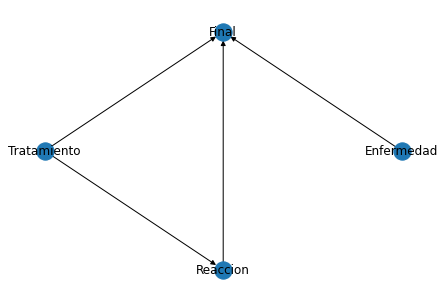

<Figure size 432x288 with 0 Axes>

In [34]:
COMPLETE_MODEL.save_digraph_as_img("figures/gt_graph")

## Aprendizaje

In [35]:
variables = sorted(["Tratamiento", "Reaccion", "Enfermedad", "Final"])
connection_tables = create_pij(variables, causal_order, invalid_edges)
connection_probas = dict()

# connection_tables["Enfermedad->Final"] = 0.95
# connection_tables["Enfermedad->Reaccion"] = 0.1
# connection_tables["Reaccion->Final"] = 0.95
# connection_tables["Tratamiento->Final"] = 0.95
# connection_tables["Tratamiento->Reaccion"] = 0.95
for k in connection_tables:
    print(k, connection_tables[k])
    connection_probas[k] = [connection_tables[k]]
ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)

print(ebunch)
print(nodes)

Enfermedad->Final 0.3404901716484472
Enfermedad->Reaccion 0.022069593941304033
Reaccion->Final 0.32510117919047343
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.7846377309508251
[('Tratamiento', 'Reaccion')]
['Enfermedad', 'Final']


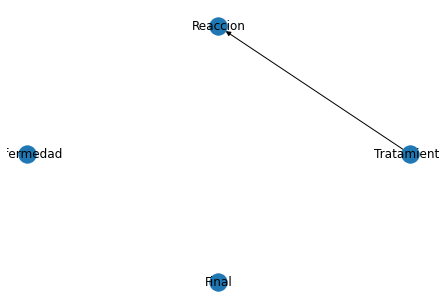

<Figure size 432x288 with 0 Axes>

In [36]:
unknown_model = deepcopy(COMPLETE_MODEL)
unknown_model.init_graph(ebunch, plot=False)
for node in nodes:
    unknown_model.digraph.add_node(node)
unknown_model.save_digraph_as_img("Nothing")
unknown_model.ebunch = ebunch
unknown_model.pgmodel = BayesianModel(ebunch)
unknown_model.pgmodel.add_nodes_from(nodes)
agent = HalfBlindAgent(nature, unknown_model)
intervention_vars = agent.model.get_intervention_variables()
target_value = 1
target = {
    "variable": agent.model.get_target_variable(),
    "value" : target_value
}
rounds = 100

### Entrenamiento

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.3404901716484472
Enfermedad->Reaccion 0.022069593941304033
Reaccion->Final 0.32510117919047343
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.7846377309508251
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+------

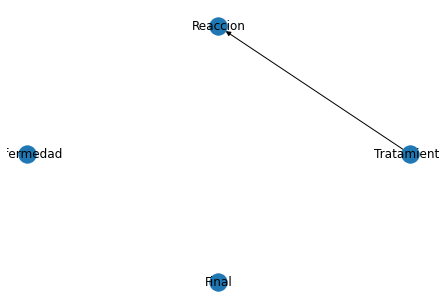

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.156730099143812
Enfermedad->Reaccion 0.003777045522473447
Reaccion->Final 0.20184812407290456
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.6566821739309902
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-------

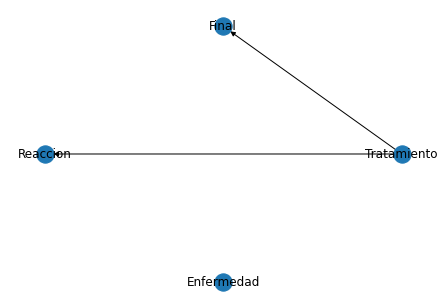

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.06271345026999066
Enfermedad->Reaccion 0.0006365439884525791
Reaccion->Final 0.11720790845073772
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.5010466251642521
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) | Enfermedad(0) |                                       0.0980 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Fina

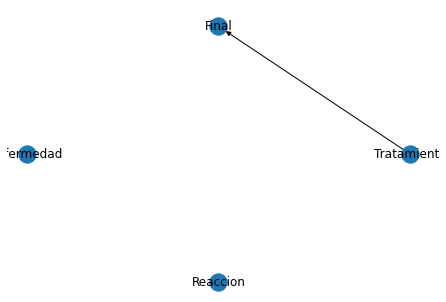

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.04474117726767258
Enfermedad->Reaccion 0.0004650336650079756
Reaccion->Final 0.11720790845073771
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.5010466251642521
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----

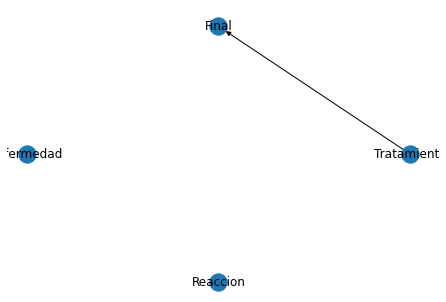

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.031744915555637424
Enfermedad->Reaccion 0.0003397193501707735
Reaccion->Final 0.1172079084507377
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.5010466251642521
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----

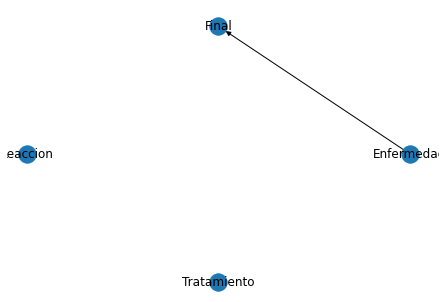

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.026801860715559338
Enfermedad->Reaccion 0.0003994860702867464
Reaccion->Final 0.15674248815044164
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.5843505307015687
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

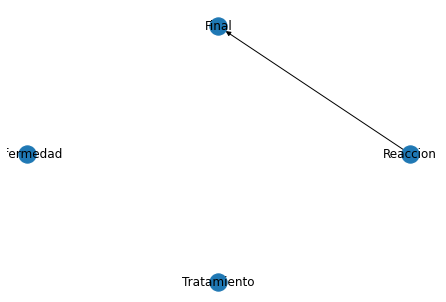

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.022610523657995842
Enfermedad->Reaccion 0.0004697625898616793
Reaccion->Final 0.20649299319501102
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.6630980613575985
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

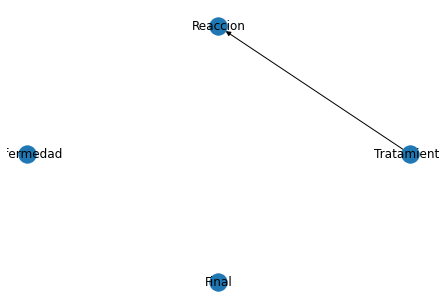

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.019061799435452394
Enfermedad->Reaccion 0.0005523951346331781
Reaccion->Final 0.2670339357979871
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.7337247122068328
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) | Enfermedad(0) |                                       0.0980 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Fina

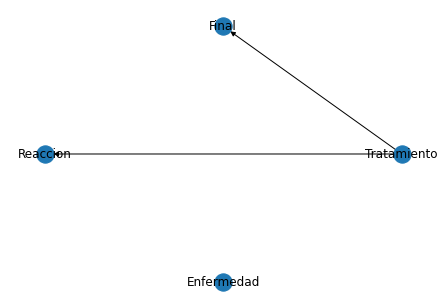

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.016060895456651764
Enfermedad->Reaccion 0.0006495535277319385
Reaccion->Final 0.3377691770243575
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.7941419636093192
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----

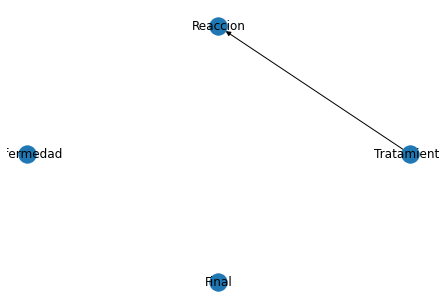

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.013525910300594506
Enfermedad->Reaccion 0.0007637876313254952
Reaccion->Final 0.41659206434290763
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.8437696077879968
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

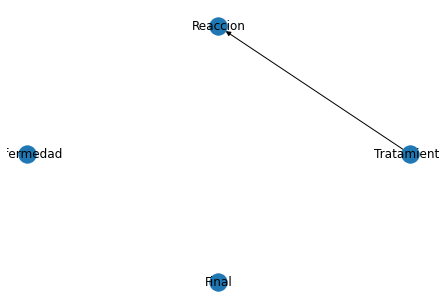

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.011386406494562035
Enfermedad->Reaccion 0.0008980935267587401
Reaccion->Final 0.4999232642185332
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.88319291507994
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+------


0it [00:00, ?it/s]


+----------------+----------+---------------+-------------------------------------+
| Tratamiento    | Final    | Enfermedad    |   phi(Tratamiento,Final,Enfermedad) |
+================+==========+===============+=====================================+
| Tratamiento(0) | Final(0) | Enfermedad(0) |                              0.1050 |
+----------------+----------+---------------+-------------------------------------+
| Tratamiento(0) | Final(0) | Enfermedad(1) |                              0.0300 |
+----------------+----------+---------------+-------------------------------------+
| Tratamiento(0) | Final(1) | Enfermedad(0) |                              0.2450 |
+----------------+----------+---------------+-------------------------------------+
| Tratamiento(0) | Final(1) | Enfermedad(1) |                              0.1200 |
+----------------+----------+---------------+-------------------------------------+
| Tratamiento(1) | Final(0) | Enfermedad(0) |                              0

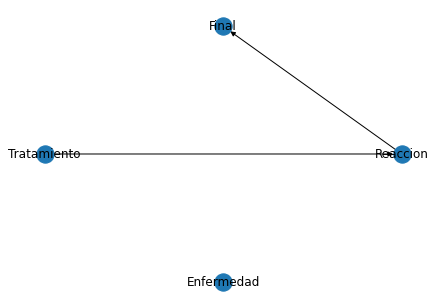

+---------------------------------+
Enfermedad->Final 0.009582038252646684
Enfermedad->Reaccion 0.0010559910728088408
Reaccion->Final 0.5832587271930316
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9136857638243044
+---------------------------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) | Enfermedad(0) |                                       0.0980 |
+-------------+----------------+----------+---------------+-------------------------------

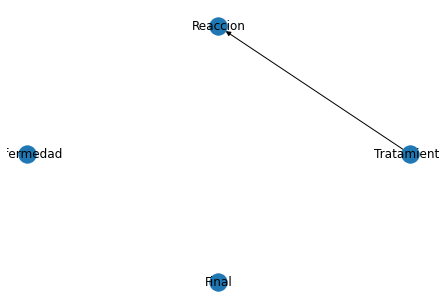

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.006726763608717251
Enfermedad->Reaccion 0.000771552238578288
Reaccion->Final 0.5832587271930316
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9136857638243044
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-----

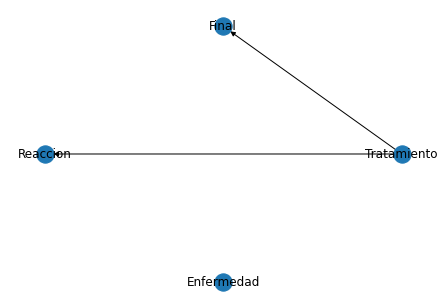

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0056565694962565066
Enfermedad->Reaccion 0.000907222237962715
Reaccion->Final 0.6620934945132179
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9367880920013278
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) | Enfermedad(0) |                                       0.0980 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Fina

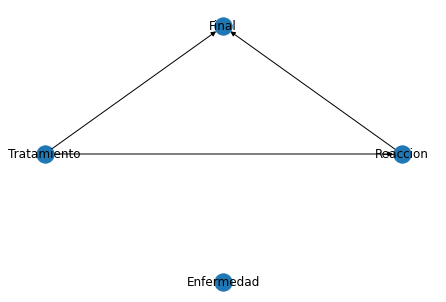

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.00475582263945898
Enfermedad->Reaccion 0.0010667230269902303
Reaccion->Final 0.7328458930190485
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9540181804154659
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-----

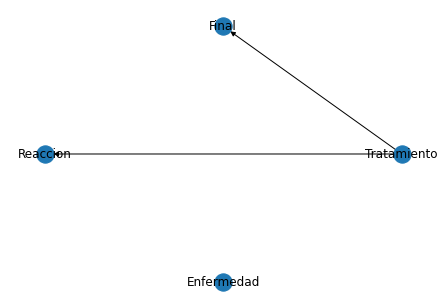

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0039979331709191915
Enfermedad->Reaccion 0.0012542308063692232
Reaccion->Final 0.7934064011852223
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9667186033897749
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

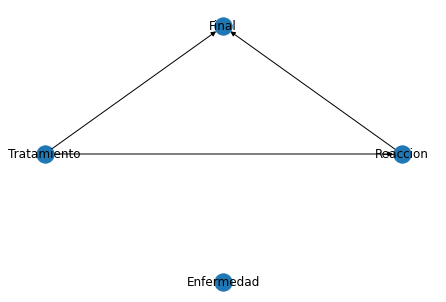

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0014429479796696817
Enfermedad->Reaccion 0.00021093088607478385
Reaccion->Final 0.6684593115695292
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.938459941818215
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-------------+----------------+----------+-----------------------------------+
| Reaccion    | Tratamiento    | Final    |   phi(Reaccion,Tratamiento,Final) |
+=============+================+==========+===================================+
| Reaccion(0) | Tratamiento(0) | Final(0) |                            0.1750 |
+-------------+----------------+----------+-----------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) |                            0.1750 |
+-------------+----------------+----------+-----------------------------------+
| Reaccion(0) | Tratamiento(1) | Final(0) |                            0.1700 |
+-------------+----------------+----------+-----------------------------------+
| Reaccion(0) | Tratamiento(1) | Final(1) |                            0.0300 |
+-------------+----------------+----------+-----------------------------------+
| Reaccion(1) | Tratamiento(0) | Final(0) |                            0.0000 |
+-------------+----------------+--------

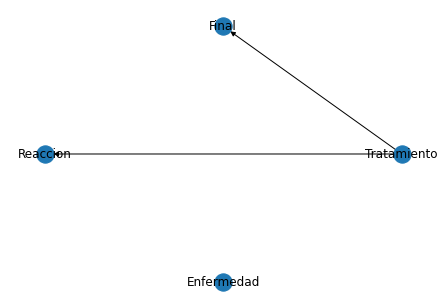

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.00043332207675154103
Enfermedad->Reaccion 6.604010748404242e-05
Reaccion->Final 0.6874525183355482
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9432974903548123
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

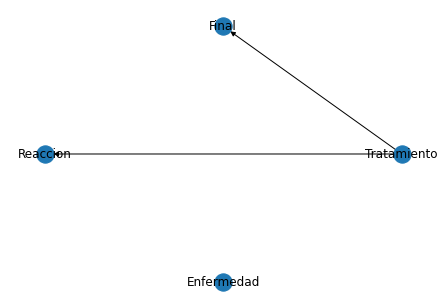

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.00030336489013734104
Enfermedad->Reaccion 4.823885030716694e-05
Reaccion->Final 0.6874525183355482
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9432974903548123
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

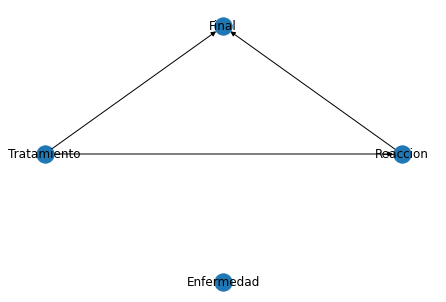

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0002548388771822432
Enfermedad->Reaccion 5.672840633492248e-05
Reaccion->Final 0.7548610686225526
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9588312440298726
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

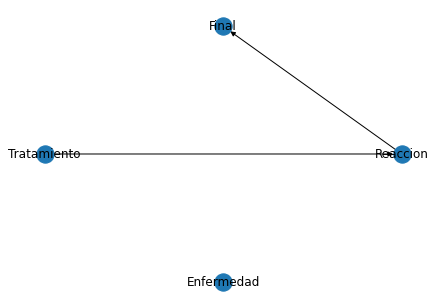

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0001784008530694956
Enfermedad->Reaccion 4.143703480433798e-05
Reaccion->Final 0.7548610686225526
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9588312440298726
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

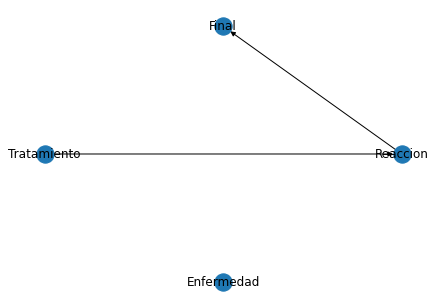

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.00014986099423105033
Enfermedad->Reaccion 4.872959754893624e-05
Reaccion->Final 0.8117132143207041
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9702437376489624
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

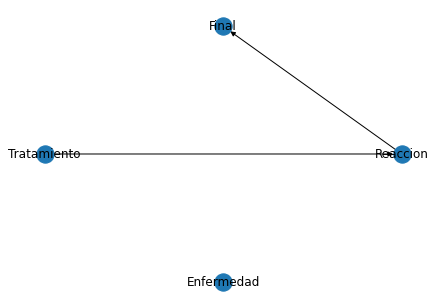

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 5.395513281588063e-05
Enfermedad->Reaccion 8.18690431008872e-06
Reaccion->Final 0.693561709790792
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9448073207146318
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-----


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) | Enfermedad(0) |                                       0.0980 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Fina

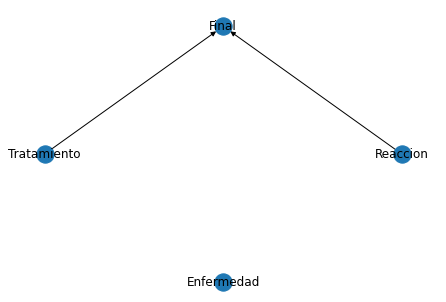

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.776920432384713e-05
Enfermedad->Reaccion 5.980012867295992e-06
Reaccion->Final 0.693561709790792
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9448073207146318
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----

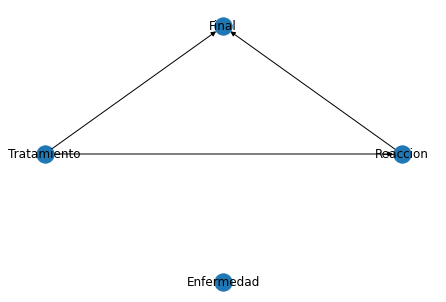

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.6438742597774366e-05
Enfermedad->Reaccion 4.368016439978203e-06
Reaccion->Final 0.693561709790792
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9448073207146318
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

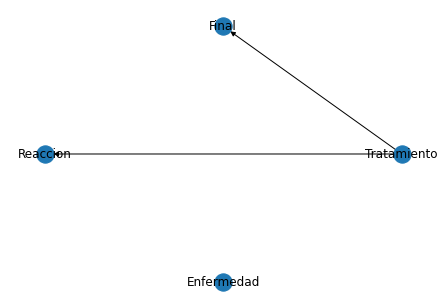

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.2208637729083488e-05
Enfermedad->Reaccion 5.136783384404815e-06
Reaccion->Final 0.7601124402342592
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9599450171323963
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

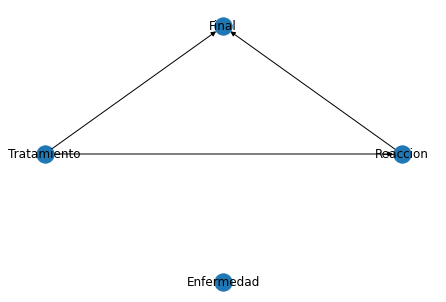

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.5546149988002392e-05
Enfermedad->Reaccion 3.75209045020832e-06
Reaccion->Final 0.7601124402342592
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9599450171323963
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

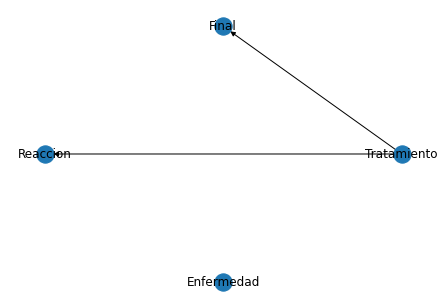

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.3058798472168363e-05
Enfermedad->Reaccion 4.412455455600957e-06
Reaccion->Final 0.8160434922387957
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9710580784743212
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

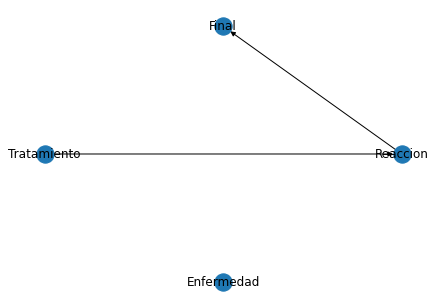

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 9.141194742423836e-06
Enfermedad->Reaccion 3.223014775079681e-06
Reaccion->Final 0.8160434922387957
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9710580784743214
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

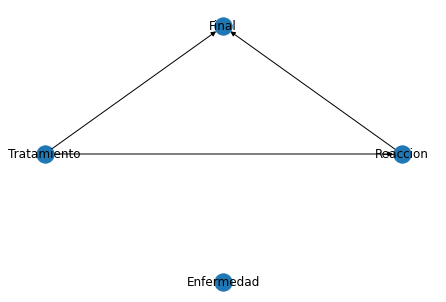

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.742375970742115e-06
Enfermedad->Reaccion 1.0089459895551933e-06
Reaccion->Final 0.8287479572411551
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9734057645785777
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

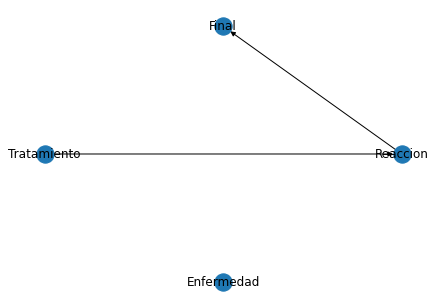

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.30359682619595e-06
Enfermedad->Reaccion 1.1865202730211698e-06
Reaccion->Final 0.8713840421694337
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9808586750124133
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

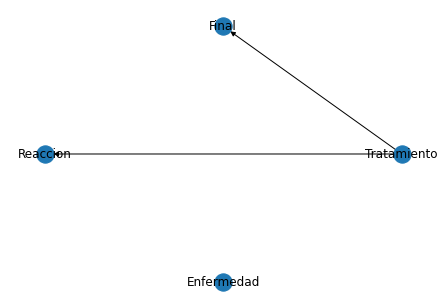

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.612518892715186e-06
Enfermedad->Reaccion 8.666759548866485e-07
Reaccion->Final 0.8713840421694337
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9808586750124133
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

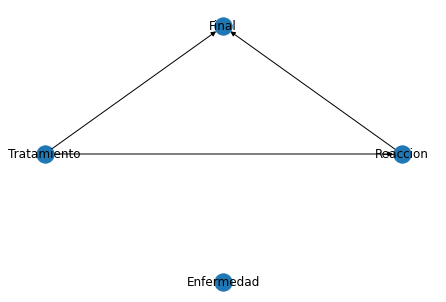

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.1287637709465021e-06
Enfermedad->Reaccion 6.330504105966533e-07
Reaccion->Final 0.8713840421694337
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9808586750124133
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

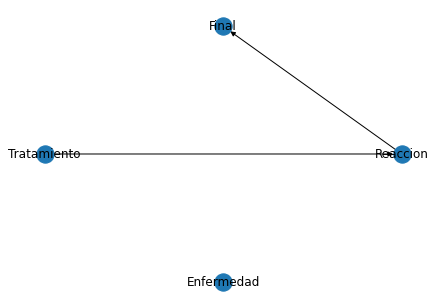

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 7.901349072252487e-07
Enfermedad->Reaccion 4.624021179526805e-07
Reaccion->Final 0.8713840421694337
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9808586750124133
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

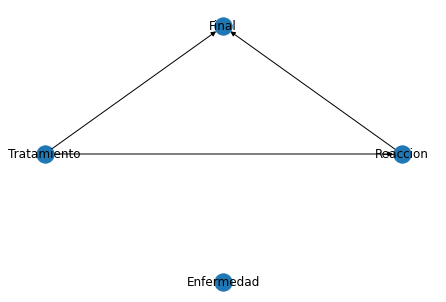

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 6.637134059769098e-07
Enfermedad->Reaccion 5.437848464576338e-07
Reaccion->Final 0.904626737697462
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9862524402922518
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----

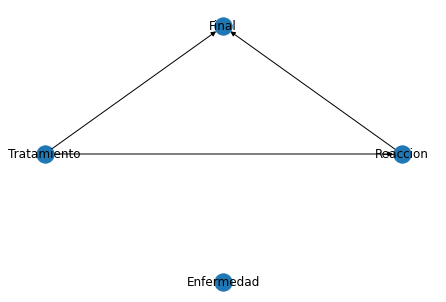

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 4.6459947669210726e-07
Enfermedad->Reaccion 3.9719942433185307e-07
Reaccion->Final 0.904626737697462
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9862524402922518
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

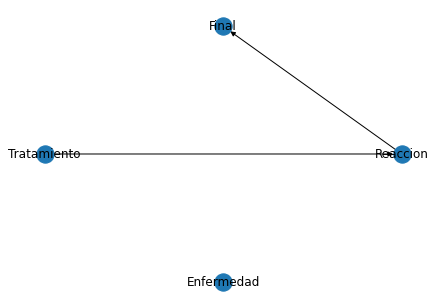

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.393798883367084e-07
Enfermedad->Reaccion 1.243407232835108e-07
Reaccion->Final 0.911874105048099
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9873836165608454
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----


0it [00:00, ?it/s]


+----------------+----------+---------------+-------------------------------------+
| Tratamiento    | Final    | Enfermedad    |   phi(Tratamiento,Final,Enfermedad) |
+================+==========+===============+=====================================+
| Tratamiento(0) | Final(0) | Enfermedad(0) |                              0.1050 |
+----------------+----------+---------------+-------------------------------------+
| Tratamiento(0) | Final(0) | Enfermedad(1) |                              0.0300 |
+----------------+----------+---------------+-------------------------------------+
| Tratamiento(0) | Final(1) | Enfermedad(0) |                              0.2450 |
+----------------+----------+---------------+-------------------------------------+
| Tratamiento(0) | Final(1) | Enfermedad(1) |                              0.1200 |
+----------------+----------+---------------+-------------------------------------+
| Tratamiento(1) | Final(0) | Enfermedad(0) |                              0

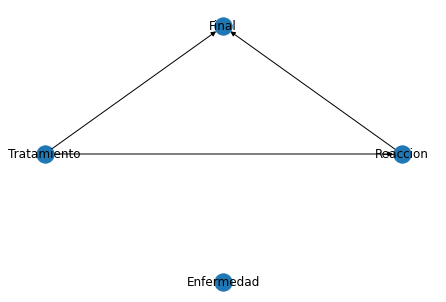

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.1707910881379072e-07
Enfermedad->Reaccion 1.462246873814324e-07
Reaccion->Final 0.9354270613168927
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9909556957117922
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

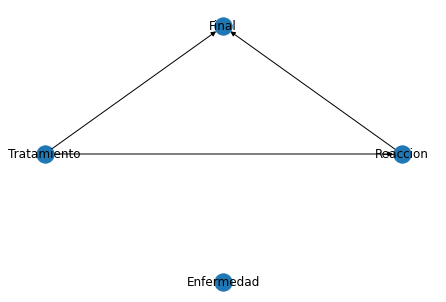

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 8.195537904823233e-08
Enfermedad->Reaccion 1.0680760194952589e-07
Reaccion->Final 0.9354270613168927
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9909556957117922
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

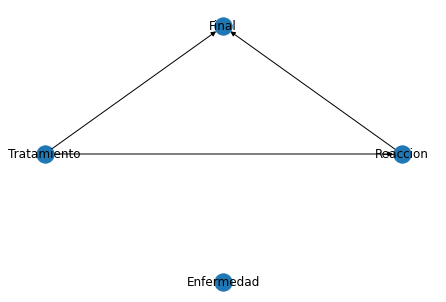

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.458661512497345e-08
Enfermedad->Reaccion 3.343542567221205e-08
Reaccion->Final 0.9404879002766233
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9917031344544235
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

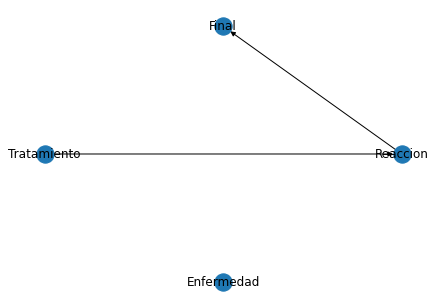

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.7210630714426765e-08
Enfermedad->Reaccion 2.4422398102431165e-08
Reaccion->Final 0.9404879002766233
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9917031344544234
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-

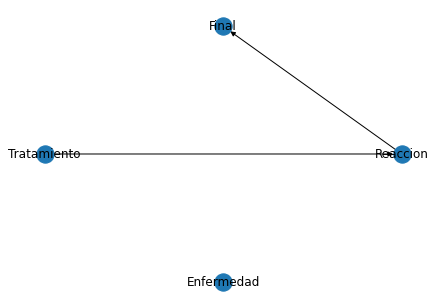

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.2047441562301955e-08
Enfermedad->Reaccion 1.7838969166173913e-08
Reaccion->Final 0.9404879002766233
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9917031344544234
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-

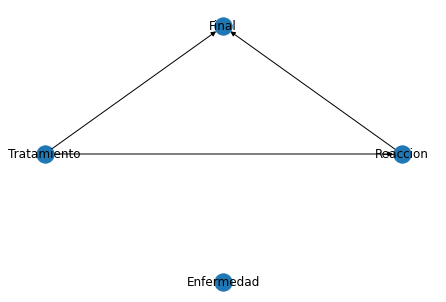

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 8.433209124090948e-09
Enfermedad->Reaccion 1.3030203627516661e-08
Reaccion->Final 0.9404879002766233
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9917031344544234
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

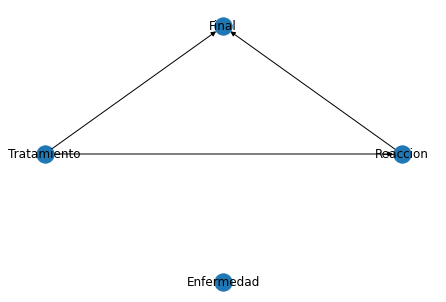

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 7.0838956737947914e-09
Enfermedad->Reaccion 1.532351943081792e-08
Reaccion->Final 0.9567560608783193
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9940595855188065
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

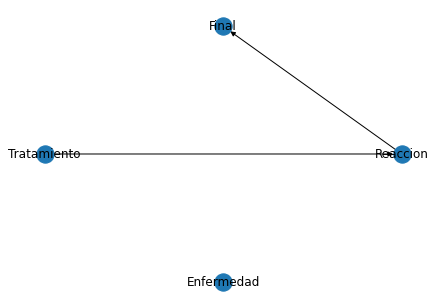

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 4.9587269821944854e-09
Enfermedad->Reaccion 1.1192831630483704e-08
Reaccion->Final 0.9567560608783193
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9940595855188064
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-

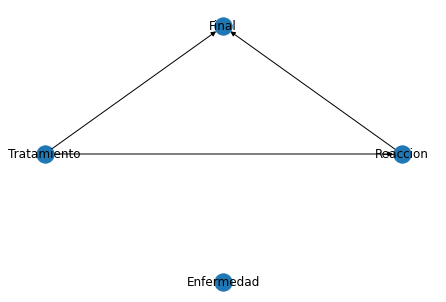

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.4711088926998243e-09
Enfermedad->Reaccion 8.175633563455603e-09
Reaccion->Final 0.9567560608783193
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9940595855188064
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

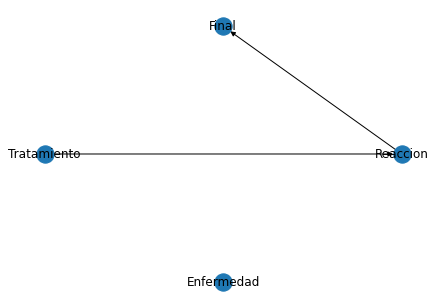

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.0413326703401525e-09
Enfermedad->Reaccion 2.5593287820644207e-09
Reaccion->Final 0.960216355680711
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9945519230726496
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

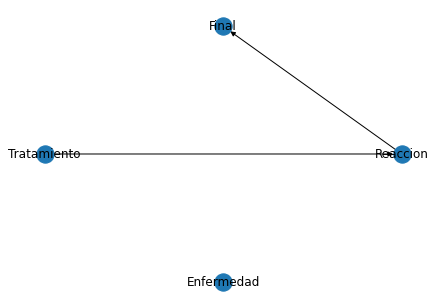

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 8.747194432314679e-10
Enfermedad->Reaccion 3.009770646352032e-09
Reaccion->Final 0.9712563896084305
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9961024495791723
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

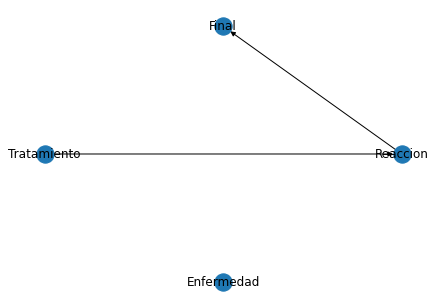

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 7.347643324172669e-10
Enfermedad->Reaccion 3.5394902782350523e-09
Reaccion->Final 0.9792988422883308
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9972129317739982
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

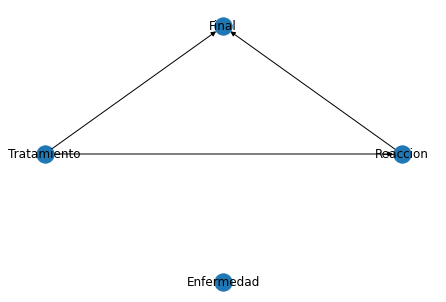

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 5.143350328054613e-10
Enfermedad->Reaccion 2.5853668143949713e-09
Reaccion->Final 0.9792988422883308
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9972129317739982
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

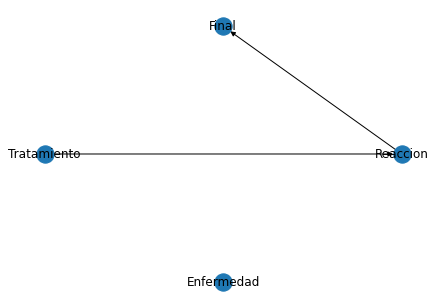

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 4.320414275921418e-10
Enfermedad->Reaccion 3.0403913723450337e-09
Reaccion->Final 0.985125481706212
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9980076504631159
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

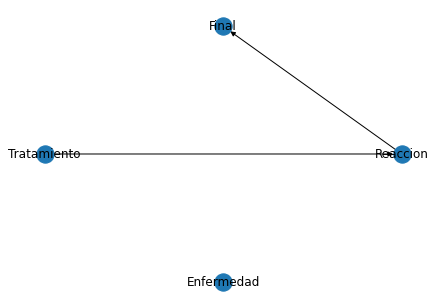

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.0242899935369784e-10
Enfermedad->Reaccion 2.220807612924336e-09
Reaccion->Final 0.985125481706212
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9980076504631159
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

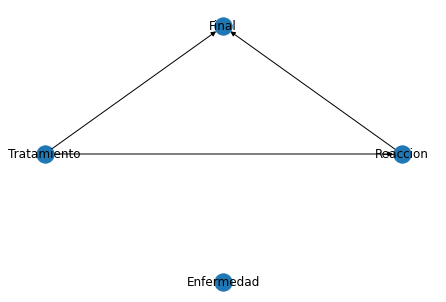

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.1170029956679576e-10
Enfermedad->Reaccion 1.622155126933231e-09
Reaccion->Final 0.985125481706212
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9980076504631159
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) | Enfermedad(0) |                                       0.0980 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Fina

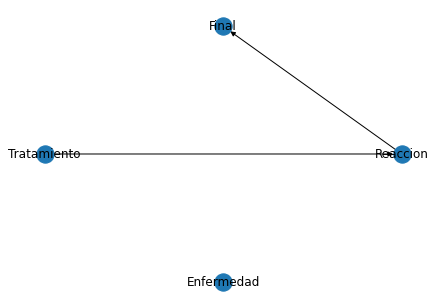

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.481902097061686e-10
Enfermedad->Reaccion 1.1848785280171753e-09
Reaccion->Final 0.985125481706212
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9980076504631159
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

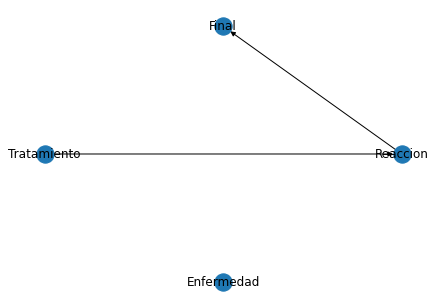

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.0373314679892969e-10
Enfermedad->Reaccion 8.654764903063716e-10
Reaccion->Final 0.985125481706212
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9980076504631159
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

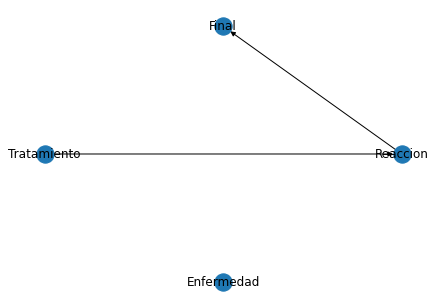

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 8.713584331254715e-11
Enfermedad->Reaccion 1.0178003524452576e-09
Reaccion->Final 0.9893299980360349
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9985760826333381
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

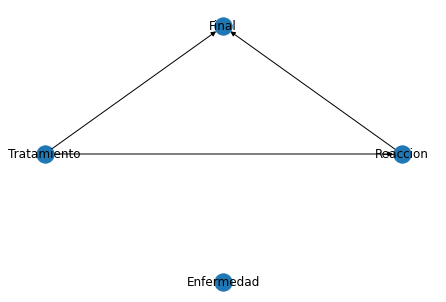

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.6140752995358604e-11
Enfermedad->Reaccion 3.186157627273736e-10
Reaccion->Final 0.9902104603324088
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.998694587513934
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-------------+----------------+----------+-----------------------------------+
| Reaccion    | Tratamiento    | Final    |   phi(Reaccion,Tratamiento,Final) |
+=============+================+==========+===================================+
| Reaccion(0) | Tratamiento(0) | Final(0) |                            0.1750 |
+-------------+----------------+----------+-----------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) |                            0.1750 |
+-------------+----------------+----------+-----------------------------------+
| Reaccion(0) | Tratamiento(1) | Final(0) |                            0.1700 |
+-------------+----------------+----------+-----------------------------------+
| Reaccion(0) | Tratamiento(1) | Final(1) |                            0.0300 |
+-------------+----------------+----------+-----------------------------------+
| Reaccion(1) | Tratamiento(0) | Final(0) |                            0.0000 |
+-------------+----------------+--------

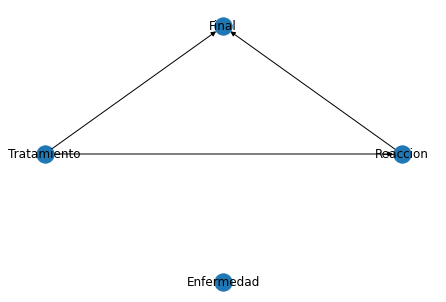

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 9.410671078486537e-12
Enfermedad->Reaccion 5.3527448152388274e-11
Reaccion->Final 0.9815169657541886
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9975164333360519
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

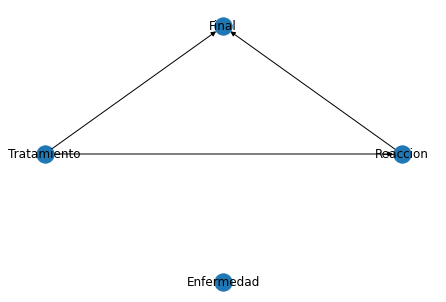

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 6.587469754959174e-12
Enfermedad->Reaccion 3.909830995535211e-11
Reaccion->Final 0.9815169657541886
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9975164333360519
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

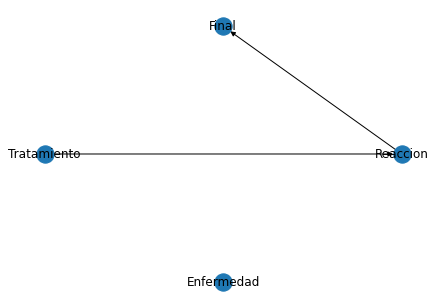

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 5.533474594171538e-12
Enfermedad->Reaccion 4.597961250717768e-11
Reaccion->Final 0.9867277436620163
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9982247641209944
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

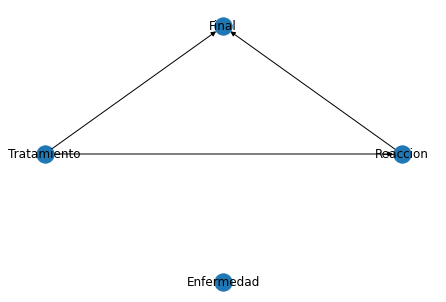

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.8734322159265065e-12
Enfermedad->Reaccion 3.358510826652867e-11
Reaccion->Final 0.9867277436620163
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9982247641209944
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

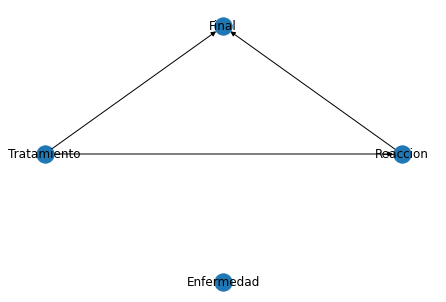

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.1620296647811027e-12
Enfermedad->Reaccion 1.0513599109764582e-11
Reaccion->Final 0.9878202940085116
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9983724596719127
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-

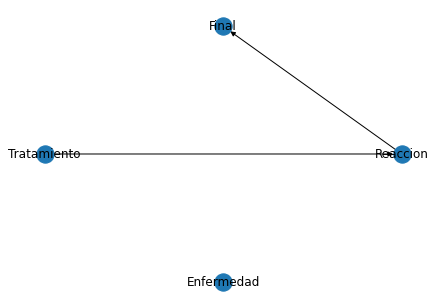

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 8.134207653470555e-13
Enfermedad->Reaccion 7.679498480197633e-12
Reaccion->Final 0.9878202940085116
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9983724596719126
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

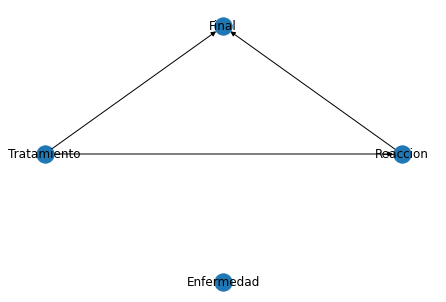

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 5.693945357430778e-13
Enfermedad->Reaccion 5.609372802938579e-12
Reaccion->Final 0.9878202940085116
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9983724596719126
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

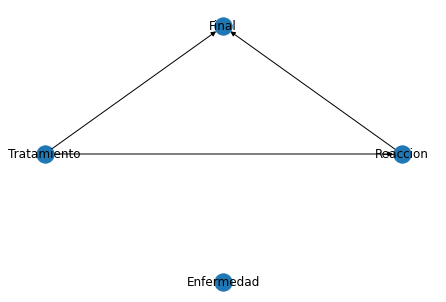

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.9857617502022257e-13
Enfermedad->Reaccion 4.097281003891767e-12
Reaccion->Final 0.9878202940085116
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9983724596719126
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

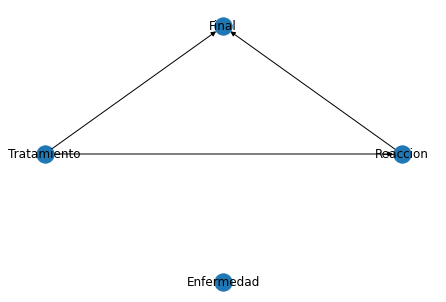

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.3480398701700834e-13
Enfermedad->Reaccion 4.818402460573242e-12
Reaccion->Final 0.9912698297469545
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9988369303534363
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

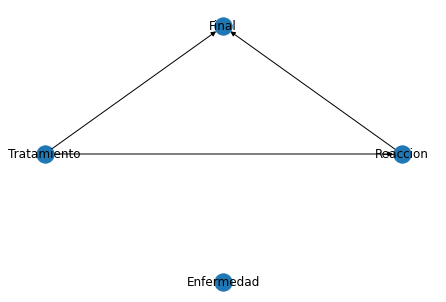

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.2052943532614882e-13
Enfermedad->Reaccion 8.094916133795499e-13
Reaccion->Final 0.9835014220179898
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9977869580311584
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

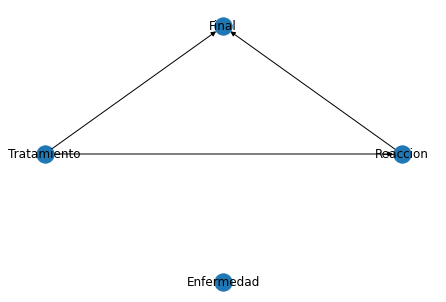

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.0124472567396697e-13
Enfermedad->Reaccion 9.519621373342148e-13
Reaccion->Final 0.9881594866893635
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.998418255603189
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(1) | Enfermedad(0) |                                       0.0980 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Fina

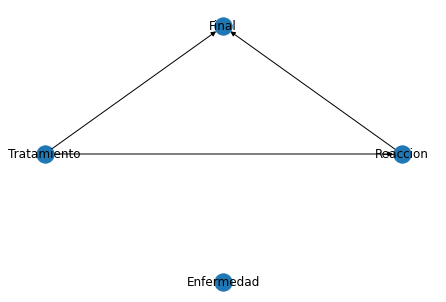

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 7.087130797177902e-14
Enfermedad->Reaccion 6.953462568356051e-13
Reaccion->Final 0.9881594866893636
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9984182556031891
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

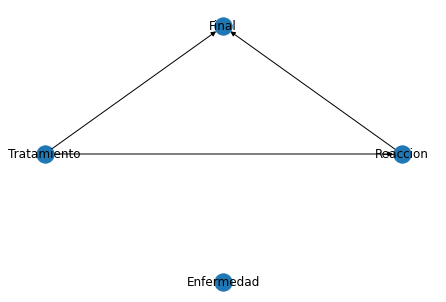

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.551367086984161e-14
Enfermedad->Reaccion 1.1681817114844924e-13
Reaccion->Final 0.9776856910544857
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9969914590590622
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

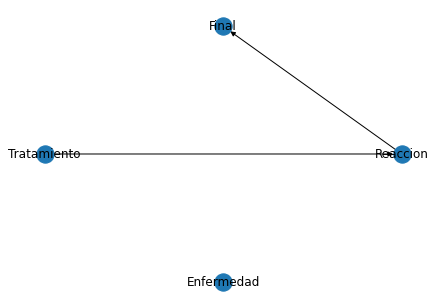

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.785956960888926e-14
Enfermedad->Reaccion 8.532805544756562e-14
Reaccion->Final 0.9776856910544858
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9969914590590622
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

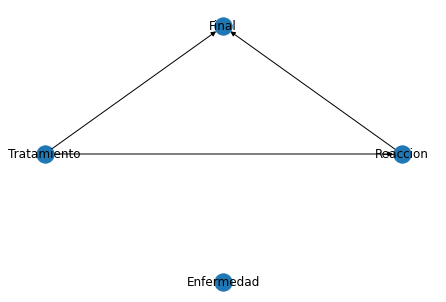

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.250169872622255e-14
Enfermedad->Reaccion 6.232657963126676e-14
Reaccion->Final 0.9776856910544858
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9969914590590622
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

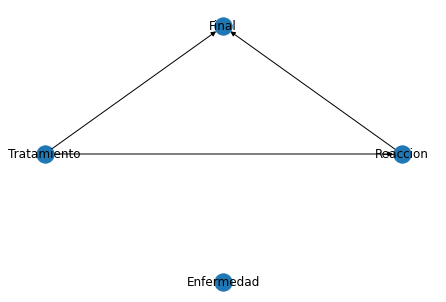

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.0501426930026965e-14
Enfermedad->Reaccion 7.32960576463689e-14
Reaccion->Final 0.9839589378340656
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9978491933879734
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

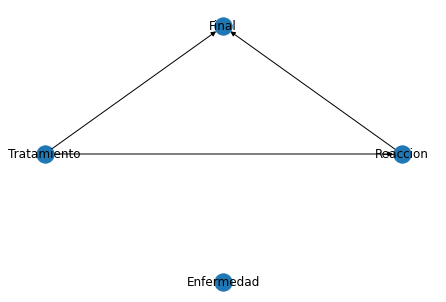

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 7.350998851018899e-15
Enfermedad->Reaccion 5.353798993300094e-14
Reaccion->Final 0.9839589378340656
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9978491933879734
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

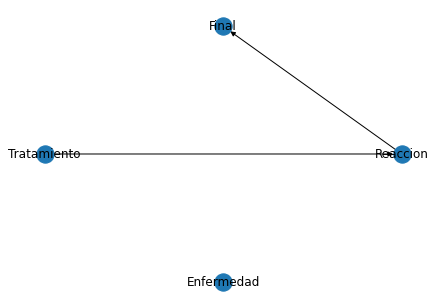

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 5.145699195713241e-15
Enfermedad->Reaccion 3.9106010038018636e-14
Reaccion->Final 0.9839589378340656
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9978491933879734
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

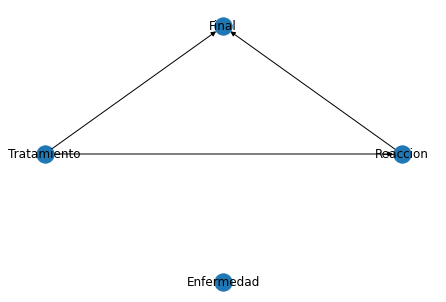

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 4.322387324399126e-15
Enfermedad->Reaccion 4.5988667804709596e-14
Reaccion->Final 0.9884893432642559
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9984627649070089
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

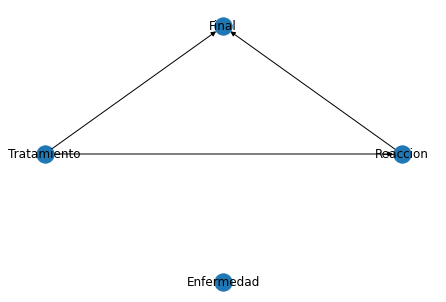

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.630805352495268e-15
Enfermedad->Reaccion 5.408267333833804e-14
Reaccion->Final 0.9917509732701567
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9989014924580512
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

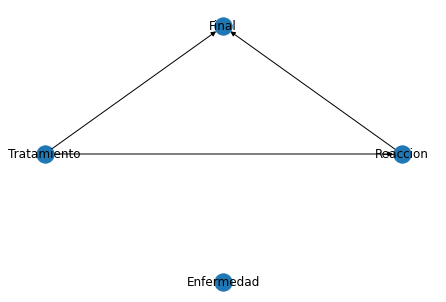

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.3070899268982998e-15
Enfermedad->Reaccion 9.0858891208412e-15
Reaccion->Final 0.9844039676416445
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9979096822232886
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----

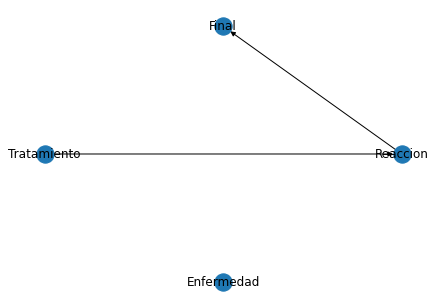

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 9.149629488288102e-16
Enfermedad->Reaccion 6.636649444788371e-15
Reaccion->Final 0.9844039676416445
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9979096822232886
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

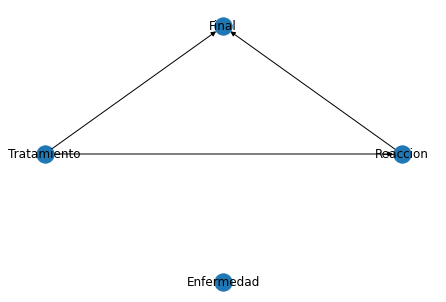

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 6.404740641801674e-16
Enfermedad->Reaccion 4.847639594454123e-15
Reaccion->Final 0.9844039676416445
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9979096822232886
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

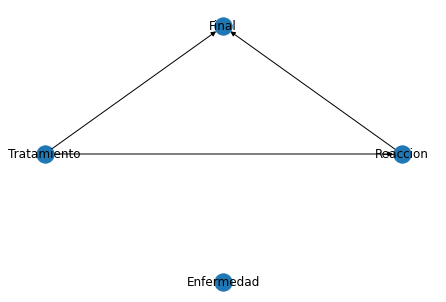

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 5.379982139113407e-16
Enfermedad->Reaccion 5.700824163078044e-15
Reaccion->Final 0.9888101146543354
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9985060236208109
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

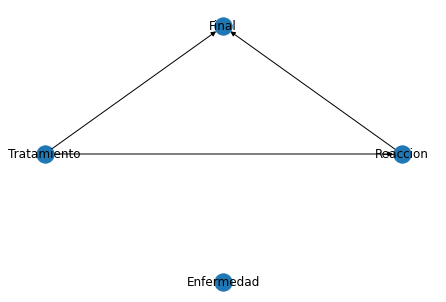

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.7659874973793856e-16
Enfermedad->Reaccion 4.1640802582483166e-15
Reaccion->Final 0.9888101146543354
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9985060236208109
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-

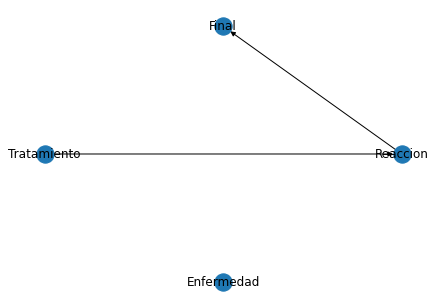

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.1634294977986835e-16
Enfermedad->Reaccion 4.8969583837000165e-15
Reaccion->Final 0.9919815890103457
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9989324183172029
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-

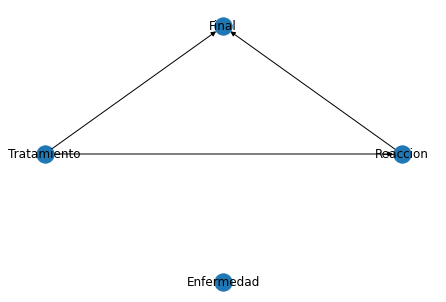

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.657280778150894e-16
Enfermedad->Reaccion 5.758823059231214e-15
Reaccion->Final 0.9942594120377888
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9992372089860838
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

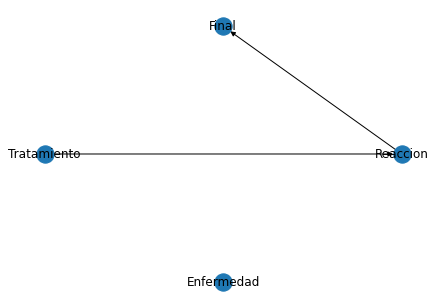

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.232115853646751e-16
Enfermedad->Reaccion 6.7723759176558996e-15
Reaccion->Final 0.9958928436005389
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9994550305049645
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

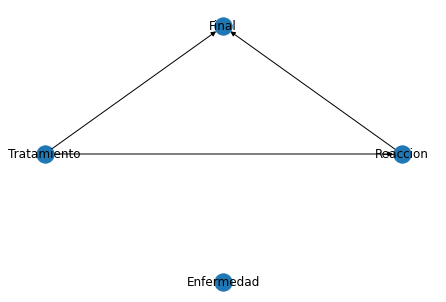

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.874977317063271e-16
Enfermedad->Reaccion 7.964314079163327e-15
Reaccion->Final 0.9970628702142719
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9996106754549744
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

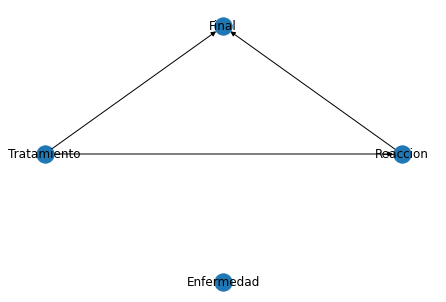

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.5749809463331476e-16
Enfermedad->Reaccion 9.36603335709606e-15
Reaccion->Final 0.9979002881169619
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9997218801024381
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

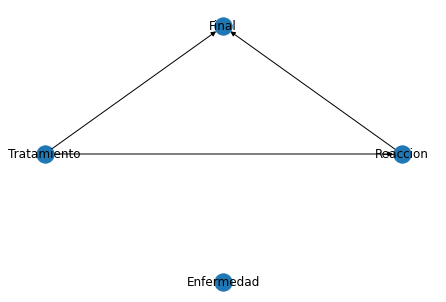

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.1024866624332033e-16
Enfermedad->Reaccion 6.8412765390962695e-15
Reaccion->Final 0.997900288116962
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9997218801024381
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

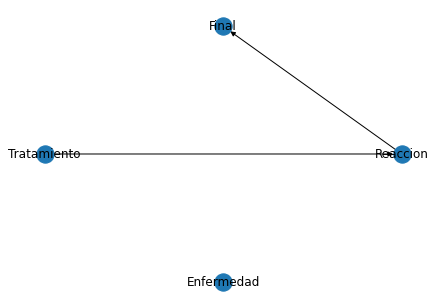

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.3074599872996104e-17
Enfermedad->Reaccion 2.1416170035431905e-15
Reaccion->Final 0.9980749272657071
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.999745050851699
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

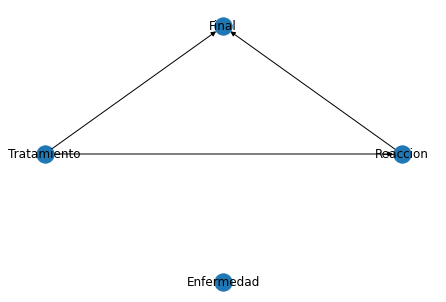

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.778266389331673e-17
Enfermedad->Reaccion 2.5185415961667906e-15
Reaccion->Final 0.9986241913235706
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.999817880199417
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

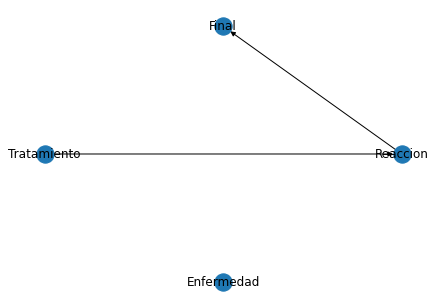

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.3337437670386054e-17
Enfermedad->Reaccion 2.9618049170921443e-15
Reaccion->Final 0.999016893069109
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9998699076589003
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

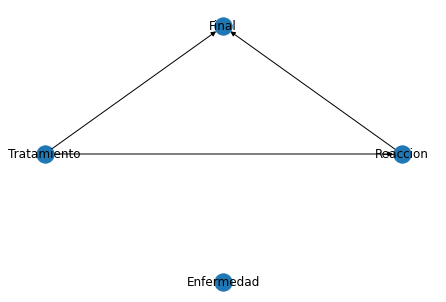

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.9603447643124287e-17
Enfermedad->Reaccion 3.48308258250036e-15
Reaccion->Final 0.9992975834634877
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9999070734452051
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

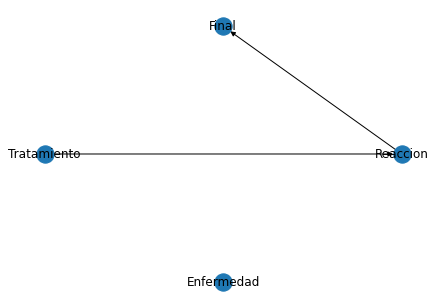

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.6466896020224402e-17
Enfermedad->Reaccion 4.0961051170204206e-15
Reaccion->Final 0.9994981731906486
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9999336221270703
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+-

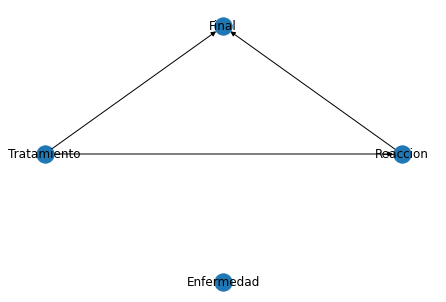

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 5.928082567280784e-18
Enfermedad->Reaccion 6.88145659659433e-16
Reaccion->Final 0.9990445732067975
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9998735735490127
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+----

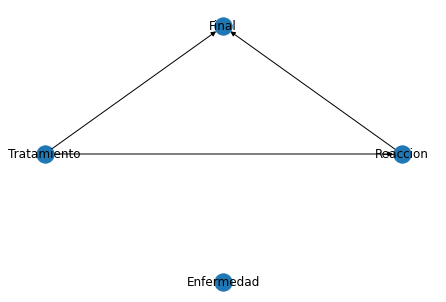

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 4.9795893565158585e-18
Enfermedad->Reaccion 8.09259295759493e-16
Reaccion->Final 0.9993173659457509
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9999096921300652
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

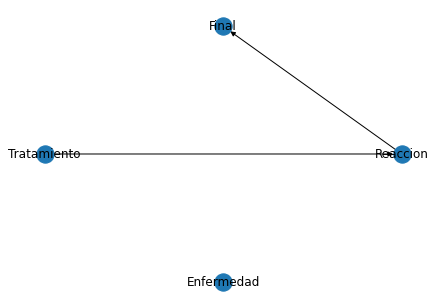

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.4857125495611015e-18
Enfermedad->Reaccion 5.911111377721515e-16
Reaccion->Final 0.9993173659457509
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9999096921300652
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

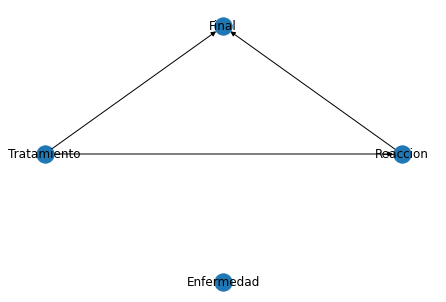

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.439998784692771e-18
Enfermedad->Reaccion 4.317681354161804e-16
Reaccion->Final 0.9993173659457509
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9999096921300652
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

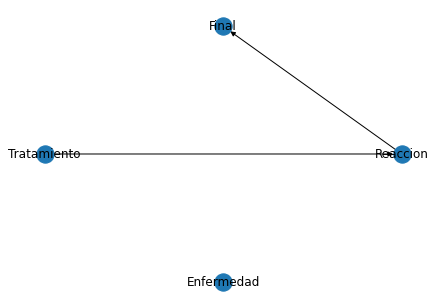

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.7079991492849396e-18
Enfermedad->Reaccion 3.153784641300796e-16
Reaccion->Final 0.9993173659457509
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9999096921300652
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+----------------+--------------------------+
| Final    | Tratamiento    |   phi(Final,Tratamiento) |
+==========+================+==========================+
| Final(0) | Tratamiento(0) |                   0.1250 |
+----------+----------------+--------------------------+
| Final(0) | Tratamiento(1) |                   0.2125 |
+----------+----------------+--------------------------+
| Final(1) | Tratamiento(0) |                   0.3750 |
+----------+----------------+--------------------------+
| Final(1) | Tratamiento(1) |                   0.2875 |
+----------+----------------+--------------------------+
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermed

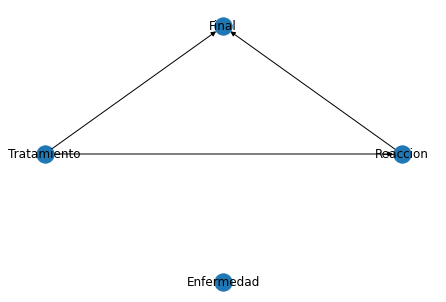

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.1955994044994577e-18
Enfermedad->Reaccion 2.30363399886319e-16
Reaccion->Final 0.9993173659457509
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.9999096921300652
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+---

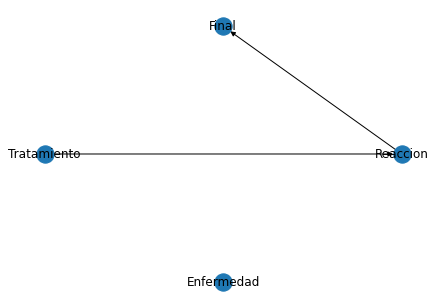

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.0043034997795445e-18
Enfermedad->Reaccion 2.7090735826631115e-16
Reaccion->Final 0.9995123091285659
Tratamiento->Final 0.5477399047939903
Tratamiento->Reaccion 0.999935492714185
+---------------------------------+
Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion    | Tratamiento    | Final    | Enfermedad    |   phi(Reaccion,Tratamiento,Final,Enfermedad) |
+=============+================+==========+===============+==============================================+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(0) |                                       0.1470 |
+-------------+----------------+----------+---------------+----------------------------------------------+
| Reaccion(0) | Tratamiento(0) | Final(0) | Enfermedad(1) |                                       0.0420 |
+-------------+----------------+--

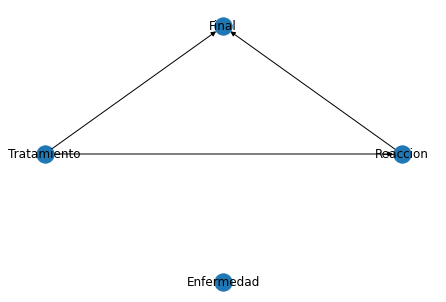

<Figure size 432x288 with 0 Axes>

In [37]:
for rnd in range(rounds):
    print("+---------------------------------+")
    for pair in connection_tables:
        print(pair, connection_tables[pair])
    print("+---------------------------------+")
    best_actions = agent.make_decision(target, intervention_vars)
    nature_response = agent.nature.action_simulator(intervention_vars, best_actions)
    agent.rewards_per_round.append(nature_response[target["variable"]])
    for var in nature_response:
        print("{} = {}".format(var, nature_response[var]))
    connection_tables = update_connection_beliefs(variables, connection_tables, COMPLETE_MODEL)
    for k in connection_tables:
        connection_probas[k] += [connection_tables[k]]
    ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)
    unknown_model.init_graph(ebunch, plot=False)
    for node in nodes:
        unknown_model.digraph.add_node(node)
    unknown_model.save_digraph_as_img("Nothing")
    unknown_model.ebunch = ebunch
    unknown_model.pgmodel = BayesianModel(ebunch)
    unknown_model.pgmodel.add_nodes_from(nodes)
    agent = HalfBlindAgent(nature, unknown_model)

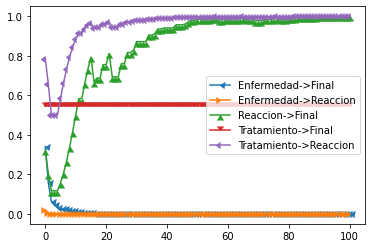

In [38]:
plot_probabilities(connection_probas)